<a href="https://colab.research.google.com/github/kyulee-jeon/Tutorial/blob/main/wk13_DeepLearning_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("googledrive")
#Connection to GoogleDrive 
library("googledrive")
####COLAB only####
# Check if is running in Colab and redefine is_interactive()
## You need to check python version (As of Nov 2022, it's 3.7)
if (file.exists("/usr/local/lib/python3.7/dist-packages/google/colab/_ipython.py")) { 
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)
}

In [ ]:
#file download
googledrive::drive_auth(use_oob = TRUE, cache = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-dpeg5tt0et3go5of2374d83ifevk5086.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AfgeXvsS2t9rBXWpzp7KLMCMxaUR169pPh7go8TRNqgeBIiLifk7Vm_xYXo


In [ ]:
install.packages("reticulate")
install.packages("abind")
install.packages("caret")
install.packages("torch")
# needed to compile magick (needed by torchvision)
system("sudo apt-get install libmagick++-dev")
install.packages("torchvision")
  
# torch_tensor(1, device = "cuda")
torch::install_torch()
# Cuda 11.2 detected but torch only supports: cpu, 10.2, 11.3, 11.6
# As of Nov 2022, current cuda is not supported by R Torch

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘coro’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘jpeg’


Cuda 11.2 detected but torch only supports: cpu, 10.2, 11.3, 11.6



In [ ]:
#file download
list_x_id <- googledrive::drive_get("list_x_wk10")
list_y_id <- googledrive::drive_get("list_y_wk10")

#download the file from the drive
googledrive::drive_download(list_x_id[1,])
googledrive::drive_download(list_y_id[1,])

In [ ]:
library(dplyr)
random_seed = 11

pd <- reticulate::import("pandas")
list_x <- pd$read_pickle("list_x_wk10")
list_y <- pd$read_pickle("list_y_wk10")




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
set.seed(random_seed)
ind <- sample(length(list_y), 300)
#subset only 300 samples
list_x <- list_x[ind]
list_y <- list_y[ind]

In [ ]:
###one hot encoding of outcome
data_y <- list_y %>% 
  as.factor() %>% 
  as.integer() ###Caution! output should be start from 1 (not 0!!!)

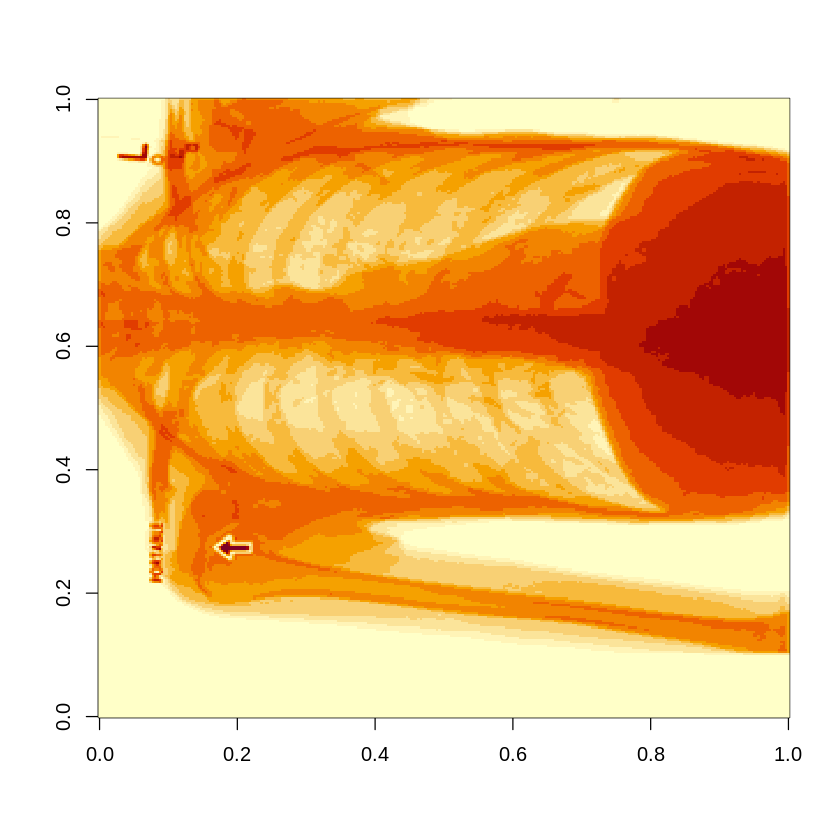

[1] 299 299

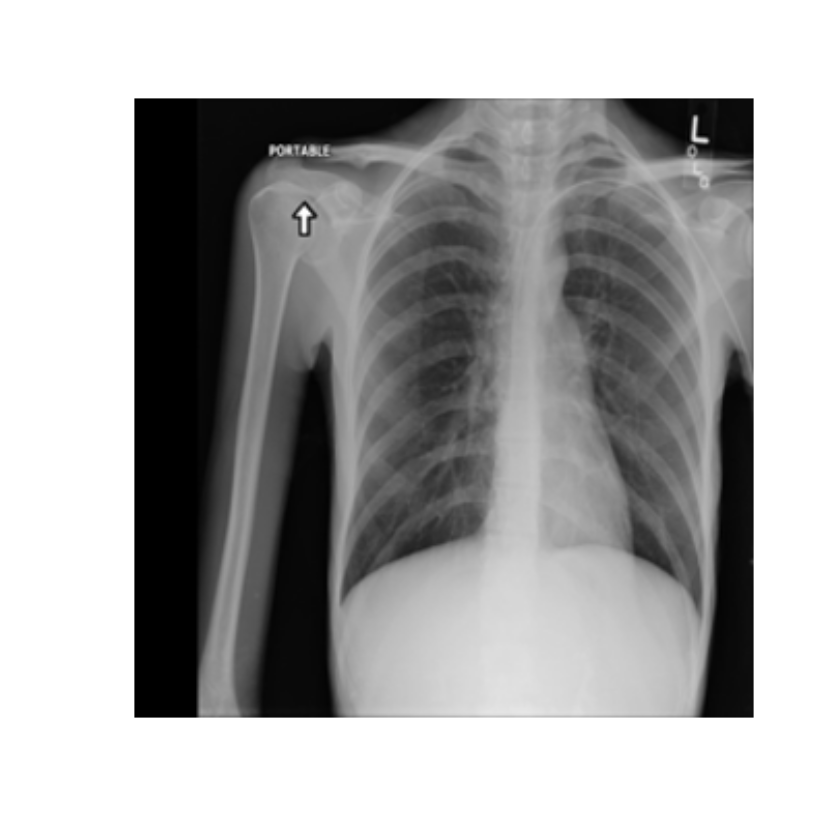

In [ ]:
###Gray scale to RGB###
list_x[[1]] %>% image()
list_x[[1]] %>% 
  as.raster(max = 255) %>%
  plot()

x<- list_x[[1]] %>% 
  as.raster(max = 255) %>% dim()

dim(list_x[[1]])
x<- list_x[[1]] %>% 
  as.raster(max = 255) %>%
  col2rgb() %>% array(dim=c(3,299,299))

In [ ]:
###list to array###
list_x_rgb <- lapply(list_x, function(x) (x %>%
                                            as.raster(max = 255) %>% 
                                            #identical to `as.raster(x/255)`
                                            col2rgb() %>%
                                            array(dim=c(3,299,299)) %>%
                                            aperm(c(2,3,1)) #RGB channel as last dimension
                                          )
                     )


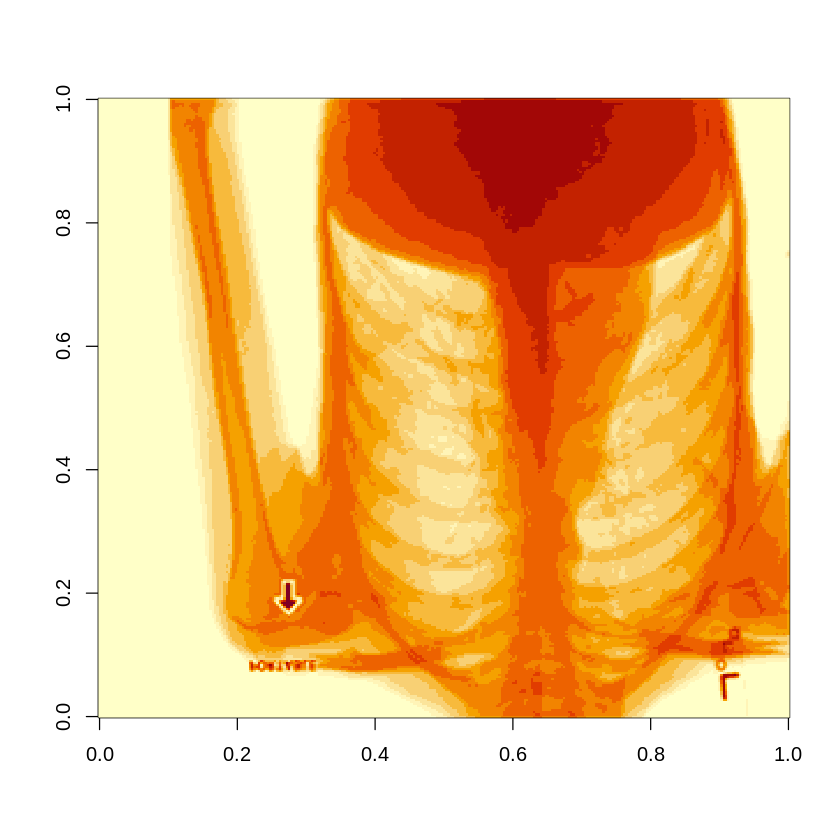

In [ ]:
data_x <- abind::abind(list_x_rgb, along = 0)
image(data_x[1,,,1])

In [ ]:
dim(data_x)

[1] 300 299 299   3

In [ ]:
###splitting into train/validation, and test####
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2

set.seed(random_seed)
test_val_ind <- list_y %>%
  as.factor() %>%
  caret::createDataPartition(p = val_prop+test_prop, list = F) #To split total data set while preserving the proportion of outcomes in train and test set

set.seed(random_seed)
test_ind_ <- list_y[test_val_ind] %>%
  as.factor() %>%
  caret::createDataPartition(p = test_prop/(val_prop+test_prop), list = F) #To split total data set while preserving the proportion of outcomes in train and test set

train_ind <- seq(dim(data_x)[1])[-test_val_ind]
test_ind <- test_val_ind[test_ind_]
val_ind <- test_val_ind[-test_ind_]

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [ ]:
###torch####
library(torch)
library(torchvision)

if(cuda_is_available()){
  device = "cuda"
}else{
  device = "cpu"
}
device

[1] "cpu"

In [ ]:
###Define Transformation###
mean_nums = c(0.485, 0.456, 0.406) #normalization for ResNet
std_nums = c(0.229, 0.224, 0.225) #normalization for ResNet

train_transforms <- function(img) {
  img %>%
    # first convert image to tensor
    torchvision::transform_to_tensor() %>%
    # then move to the GPU (if available)
    #(function(x) x$to(device = device)) %>%
    # # data augmentation
    # transform_random_rotation(degrees = 15) %>% #error occured, not debugged
    # torchvision::transform_random_resized_crop(size = c(224, 224)) %>%
    torchvision::transform_color_jitter() %>%
    torchvision::transform_random_horizontal_flip() %>%

    # normalize according to what is expected by resnet
    transform_normalize(mean = mean_nums, std = std_nums)
}
val_transforms <- function(img) {
  img %>%
    # first convert image to tensor
    torchvision::transform_to_tensor() %>%
    # then move to the GPU (if available)
    #(function(x) x$to(device = device)) %>%
    # normalize according to what is expected by resnet
    transform_normalize(mean = mean_nums, std = std_nums)
}
test_transforms = val_transforms

In [ ]:
fromArrayDataset <- torch::dataset(
  name = "image_array_to_dataset",
  
  initialize = function(x, y, indices, transform = NULL){
    self$x <- x[indices,,,]
    self$y <- y[indices]  %>%
      torch::torch_tensor(dtype = torch::torch_long()) 
    #tensorize y at 'initialize' phase. Tensorization of y at 'getitem' phase makes another dimension
    self$transform <- transform
  },
  
  .getitem = function(i){
    x = self$x[i,,,]
    y = self$y[i]
    
    if(!is.null(self$transform)){
      x = self$transform(x)
    } else {
      x = torch::torch_tensor(x, dtype = torch::torch_float()) #%>%
      #(function(x) x$to(device = device))
    }
    # y = torch::torch_tensor(y, dtype = torch::torch_long()) #%>%
    #(function(x) x$to(device = device))
    
    list(x=x, y=y)
  },
  
  .length = function(){
    length(self$y)
  }
)

In [ ]:
train_ds = fromArrayDataset(data_x, data_y, train_ind, transform = train_transforms)
valid_ds = fromArrayDataset(data_x, data_y, val_ind, transform = val_transforms)
test_ds = fromArrayDataset(data_x, data_y, test_ind, transform = test_transforms)

batch_size = 32

train_dl <- torch::dataloader(train_ds, batch_size = batch_size, shuffle = TRUE)
valid_dl <- torch::dataloader(valid_ds, batch_size = batch_size, shuffle = TRUE)
test_dl <- torch::dataloader(test_ds, batch_size = batch_size, shuffle = TRUE)

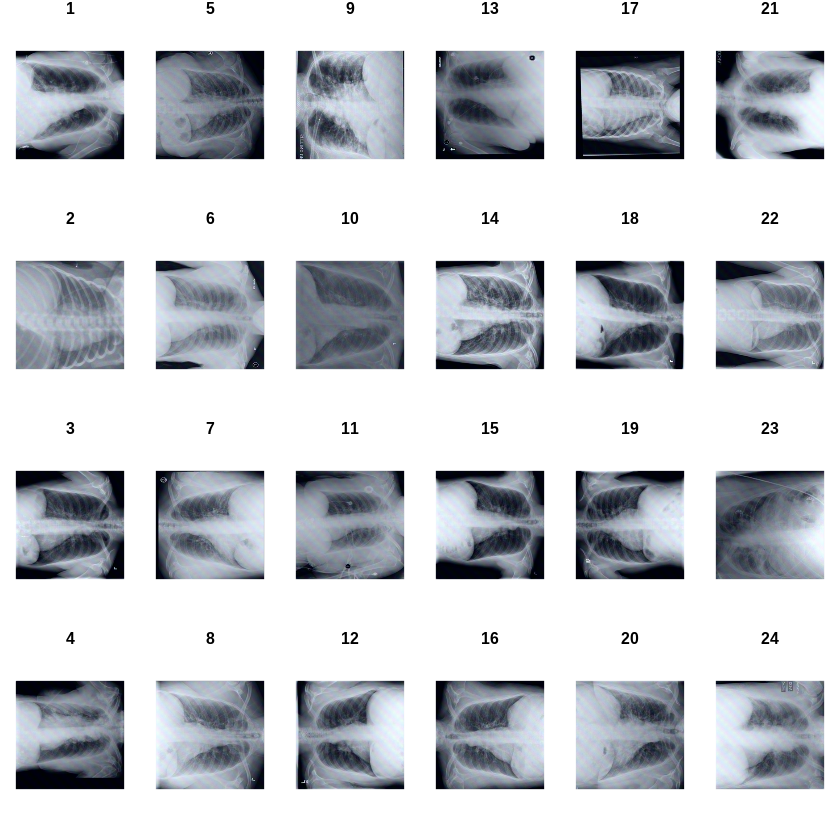

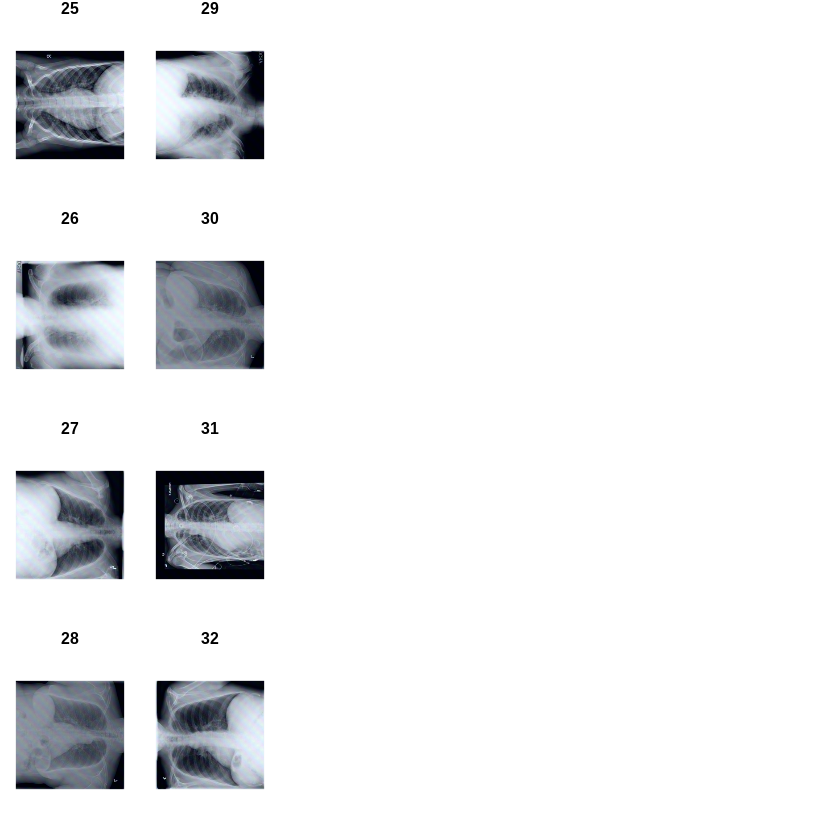

In [ ]:
batch <- train_dl$.iter()$.next()
###Image view####
images <- as_array(batch[[1]]) %>% aperm(perm = c(1, 3, 4, 2))

mean <- c(0.485, 0.456, 0.406)
std <- c(0.229, 0.224, 0.225)
images <- std * images + mean
images <- images * 255
images[images > 255] <- 255
images[images < 0] <- 0

par(mfcol = c(4,6), mar = rep(1, 4))
images %>%
  purrr::array_tree(1) %>%
  #purrr::set_names(class_names[as_array(classes)]) %>%
  purrr::map(as.raster, max = 255) %>%
  purrr::iwalk(~{plot(.x); title(.y)})

In [ ]:
###model###
model <- model_resnet50(pretrained = TRUE)

model$parameters %>% purrr::walk(function(param) param$requires_grad_(FALSE))

num_features <- model$fc$in_features
out_features = data_y %>% unique() %>% length()
model$fc <- nn_linear(in_features = num_features, out_features = out_features)
model <- model$to(device = device)

In [ ]:
####training####
criterion <- nn_cross_entropy_loss()

optimizer <- optim_sgd(model$parameters, lr = 0.1, momentum = 0.9)

num_epochs = 5

scheduler <- optimizer %>% 
  lr_one_cycle(max_lr = 0.05, epochs = num_epochs, steps_per_epoch = train_dl$.length())

train_batch <- function(b) {
  
  optimizer$zero_grad()
  output <- model(b[[1]])
  loss <- criterion(output, b[[2]]$to(device = device))
  loss$backward()
  optimizer$step()
  scheduler$step()
  loss$item()
  
}

valid_batch <- function(b) {
  
  output <- model(b[[1]])
  loss <- criterion(output, b[[2]]$to(device = device))
  loss$item()
}


In [ ]:
for (epoch in 1:num_epochs) {
  
  model$train()
  train_losses <- c()
  
  coro::loop(for (b in train_dl) {
    loss <- train_batch(b)
    train_losses <- c(train_losses, loss)
  })
  
  model$eval()
  valid_losses <- c()
  
  coro::loop(for (b in valid_dl) {
    loss <- valid_batch(b)
    valid_losses <- c(valid_losses, loss)
  })
  
  cat(sprintf("\nLoss at epoch %d: training: %3f, validation: %3f\n", epoch, mean(train_losses), mean(valid_losses)))
}


Loss at epoch 1: training: 0.643694, validation: 1.340775

Loss at epoch 2: training: 2.006902, validation: 11.043289

Loss at epoch 3: training: 10.264570, validation: 1.268220

Loss at epoch 4: training: 5.529743, validation: 2.214181

Loss at epoch 5: training: 0.868818, validation: 0.656047


In [ ]:
b <- test_dl$.iter()$.next()

In [ ]:
model$eval()
output <- model(b[[1]])
labels <- b[[2]]$to(device = device)
loss <- criterion(output, labels)
  
test_losses <<- c(test_losses, loss$item())

In [ ]:
model$eval()

test_batch <- function(b) {

  output <- model(b[[1]])
  labels <- b[[2]]$to(device = device)
  loss <- criterion(output, labels)
  
  test_losses <<- c(test_losses, loss$item())
  # torch_max returns a list, with position 1 containing the values
  # and position 2 containing the respective indices
  predicted <- torch_max(output$data(), dim = 2)[[2]]
  total <<- total + labels$size(1)
  # add number of correct classifications in this batch to the aggregate
  correct <<- correct + (predicted == labels)$sum()$item()

}

test_losses <- c()
total <- 0
correct <- 0

coro::loop(for (b in test_dl) {
  test_batch(b)
})

mean(test_losses)

test_accuracy <-  correct/total
test_accuracy

[1] 1.045828

[1] 0.7704918